# Analyse results

Full scenario (no load shedding)

Useful references:
* https://pypsa.readthedocs.io/en/latest/examples/scigrid-lopf-then-pf.html (example from PyPSA documentation with many different visualisations)

## Setup and helpers

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pypsa
import yaml

# plotting settings
plt.style.use("ggplot")  # what is this?
plt.rcParams["figure.figsize"] = (6, 6)
projection = ccrs.LambertAzimuthalEqualArea(
    central_longitude=10, central_latitude=52
)  # good for Europe

# Load the network
run_name = "02-28"
scenario_name = "full"
file = "base_s_2_elec_68H-Co2L.nc"
base_path = f"../results/{run_name}/{scenario_name}"
network_file = f"{base_path}/networks/{file}"
network = pypsa.Network(network_file)

# Load the config file
with open("../config/config.yaml") as stream:
    config = yaml.safe_load(stream)


def plot_europe(ax):
    ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())  # Europe
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.COASTLINE, edgecolor="black")
    ax.add_feature(cfeature.LAND, facecolor="lightgrey")
    ax.add_feature(cfeature.LAKES, facecolor="lightblue", alpha=0.8)
    ax.add_feature(cfeature.RIVERS, edgecolor="lightblue", alpha=0.8)

    gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels

INFO:pypsa.io:Imported network base_s_2_elec_68H-Co2L.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Export static and dynamic components

In [22]:
network.export_to_csv_folder(f"{base_path}/tables/")

INFO:pypsa.io:Exported network '<unnamed>' contains: links, carriers, loads, storage_units, global_constraints, buses, generators, stores, lines


## Inspect network object

All the possible components within a network are given in https://pypsa.readthedocs.io/en/latest/user-guide/components.html

### All components

In [23]:
network.df  # simply describes types of components available in the network

<bound method Network.df of Unnamed PyPSA Network
---------------------
Components:
 - Bus: 4
 - Carrier: 15
 - Generator: 10
 - GlobalConstraint: 1
 - Line: 1
 - Link: 4
 - Load: 2
 - StorageUnit: 5
 - Store: 2
Snapshots: 129>

### Loads

In [24]:
network.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
CH0 0,CH0 0,,,0.0,0.0,-1.0,True
DE0 0,DE0 0,,,0.0,0.0,-1.0,True


### Buses

In [25]:
network.component_attrs.Bus  # look at component attributes if you need to know units, etc.

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
v_nom,float,kV,1.0,Nominal voltage,Input (optional),True,False,<class 'float'>,float64
type,string,NaN,,Placeholder for bus type. Not yet implemented.,Input (optional),True,False,<class 'str'>,object
x,float,NaN,0.0,Position (e.g. longitude); the Spatial Referen...,Input (optional),True,False,<class 'float'>,float64
y,float,NaN,0.0,Position (e.g. latitude); the Spatial Referenc...,Input (optional),True,False,<class 'float'>,float64
carrier,string,NaN,AC,"Energy carrier: can be ""AC"" or ""DC"" for electr...",Input (optional),True,False,<class 'str'>,object
unit,string,NaN,,Unit of the bus’ carrier if the implicitly ass...,Input (optional),True,False,<class 'str'>,object
v_mag_pu_set,static or series,per unit,1.0,"Voltage magnitude set point, per unit of v_nom.",Input (optional),True,True,<class 'float'>,float64
v_mag_pu_min,float,per unit,0.0,"Minimum desired voltage, per unit of v_nom. Th...",Input (optional),True,False,<class 'float'>,float64


In [26]:
network.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,substation_lv,location,substation_off,country
Bus,,,,,,,,,,,,,,,,
CH0 0,380.0,,8.297643,46.894102,AC,,1.0,0.0,inf,PQ,,,1.0,,1.0,CH
DE0 0,380.0,,9.202027,51.085260,AC,,1.0,0.0,inf,Slack,DE0 0 offwind-dc,,1.0,,1.0,DE
CH0 0 H2,1.0,,8.297643,46.894102,H2,,1.0,0.0,inf,PQ,,,NaN,CH0 0,NaN,CH
DE0 0 H2,1.0,,9.202027,51.085260,H2,,1.0,0.0,inf,PQ,,,NaN,DE0 0,NaN,DE


### Carriers

In [27]:
network.component_attrs.Carrier

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
co2_emissions,float,tonnes/MWh,0.0,Emissions in CO2-tonnes-equivalent per MWh of ...,Input (optional),True,False,<class 'float'>,float64
color,string,NaN,,plotting color,Input (optional),True,False,<class 'str'>,object
nice_name,string,NaN,,More precise descriptive name,Input (optional),True,False,<class 'str'>,object
max_growth,float,MW,inf,maximum new installed capacity per investment ...,Input (optional),True,False,<class 'float'>,float64
max_relative_growth,float,MW,0.0,maximum capacity ratio for new installed capac...,Input (optional),True,False,<class 'float'>,float64


In [28]:
network.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
DC,0.0,#8a1caf,DC,inf,0.0
AC,0.0,#70af1d,AC,inf,0.0
hydro,0.0,#298c81,Reservoir & Dam,inf,0.0
offwind-dc,0.0,#74c6f2,Offshore Wind (DC),inf,0.0
offwind-ac,0.0,#6895dd,Offshore Wind (AC),inf,0.0
onwind,0.0,#235ebc,Onshore Wind,inf,0.0
solar,0.0,#f9d002,Solar,inf,0.0
ror,0.0,#3dbfb0,Run of River,inf,0.0
PHS,0.0,#51dbcc,Pumped Hydro Storage,inf,0.0


### Generators

In [29]:
network.generators[
    ["bus", "carrier", "p_nom_opt", "p_nom_max", "p_nom_min", "marginal_cost"]
]
# generators con

,bus,carrier,p_nom_opt,p_nom_max,p_nom_min,marginal_cost
Generator,,,,,,
DE0 0 offwind-dc,DE0 0,offwind-dc,2.175411e+04,2.175411e+04,0.0,0.015
DE0 0 offwind-ac,DE0 0,offwind-ac,4.179646e+03,4.179646e+03,0.0,0.015
CH0 0 onwind,CH0 0,onwind,6.396433e-12,7.697001e+04,0.0,0.015
DE0 0 onwind,DE0 0,onwind,1.077110e+05,4.878369e+05,0.0,0.015
CH0 0 solar,CH0 0,solar,1.253695e+05,1.253695e+05,0.0,0.010
DE0 0 solar,DE0 0,solar,1.655122e+05,1.086693e+06,0.0,0.010
CH0 0 ror,CH0 0,ror,4.202621e+03,inf,0.0,0.000
DE0 0 ror,DE0 0,ror,5.237029e+03,inf,0.0,0.000
CH0 0 curtailment,CH0 0,curtailment,1.000000e+06,inf,0.0,-0.100


In [30]:
network.component_attrs.Generator  # nice table of all attributes of generators

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
bus,string,NaN,,name of bus to which generator is attached,Input (required),True,False,<class 'str'>,object
control,string,NaN,PQ,"P,Q,V control strategy for PF, must be ""PQ"", ""...",Input (optional),True,False,<class 'str'>,object
type,string,NaN,,Placeholder for generator type. Not yet implem...,Input (optional),True,False,<class 'str'>,object
p_nom,float,MW,0.0,Nominal power for limits in optimization.,Input (optional),True,False,<class 'float'>,float64
p_nom_mod,float,MW,0.0,Nominal power of the generator module.,Input (optional),True,False,<class 'float'>,float64
p_nom_extendable,boolean,NaN,False,Switch to allow capacity p_nom to be extended ...,Input (optional),True,False,<class 'bool'>,bool
p_nom_min,float,MW,0.0,"If p_nom is extendable in optimization, set it...",Input (optional),True,False,<class 'float'>,float64
p_nom_max,float,MW,inf,"If p_nom is extendable in optimization, set it...",Input (optional),True,False,<class 'float'>,float64


### Storage Units

In [31]:
network.storage_units[
    ["bus", "carrier", "p_nom_opt", "p_nom_max", "p_nom_min", "marginal_cost"]
]  # no energy columns

,bus,carrier,p_nom_opt,p_nom_max,p_nom_min,marginal_cost
StorageUnit,,,,,,
CH0 0 PHS,CH0 0,PHS,5.107550e+03,inf,0.0,0.0
DE0 0 PHS,DE0 0,PHS,7.469346e+03,inf,0.0,0.0
CH0 0 hydro,CH0 0,hydro,1.080487e+04,inf,0.0,0.0
CH0 0 battery,CH0 0,battery,4.361902e-09,inf,0.0,0.0
DE0 0 battery,DE0 0,battery,4.895931e-09,inf,0.0,0.0


### Storage

In [32]:
network.stores[
    ["bus", "carrier", "e_nom_opt", "e_nom_max", "e_nom_min", "marginal_cost"]
]  # no power columns

,bus,carrier,e_nom_opt,e_nom_max,e_nom_min,marginal_cost
Store,,,,,,
CH0 0 H2,CH0 0 H2,H2,3.308622e-06,inf,0.0,0.0
DE0 0 H2,DE0 0 H2,H2,2.933283e+07,inf,0.0,0.0


### Constraints

In [33]:
network.component_attrs.GlobalConstraint

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
type,string,NaN,primary_energy,"Type of constraint (only ""primary energy"", i.e...",Input (optional),True,False,<class 'str'>,object
investment_period,float,NaN,NaN,"time period when the constraint is applied, if...",Input (optional),True,False,<class 'float'>,float64
carrier_attribute,string,NaN,co2_emissions,If the global constraint is connected with an ...,Input (optional),True,False,<class 'str'>,object
sense,string,NaN,==,"Constraint sense; must be one of <=, == or >=",Input (optional),True,False,<class 'str'>,object
constant,float,NaN,0.0,Constant for right-hand-side of constraint for...,Input (optional),True,False,<class 'float'>,float64
mu,float,currency/constant,0.0,Shadow price of global constraint,Output,True,False,<class 'float'>,float64


## Static variables
Not dependent on t

### Network map

/Users/jopeel/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


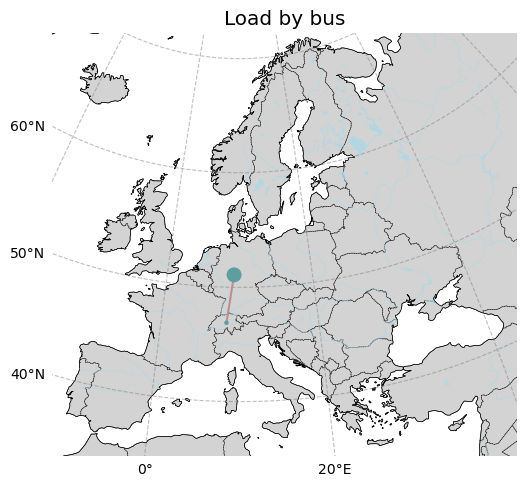

In [34]:
l_by_bus = network.loads_t.p.mean()

fig, ax = plt.subplots(subplot_kw={"projection": projection})
network.plot(ax=ax, bus_sizes=l_by_bus * 1e-5, title="Load by bus")
plot_europe(ax)

### Capacities

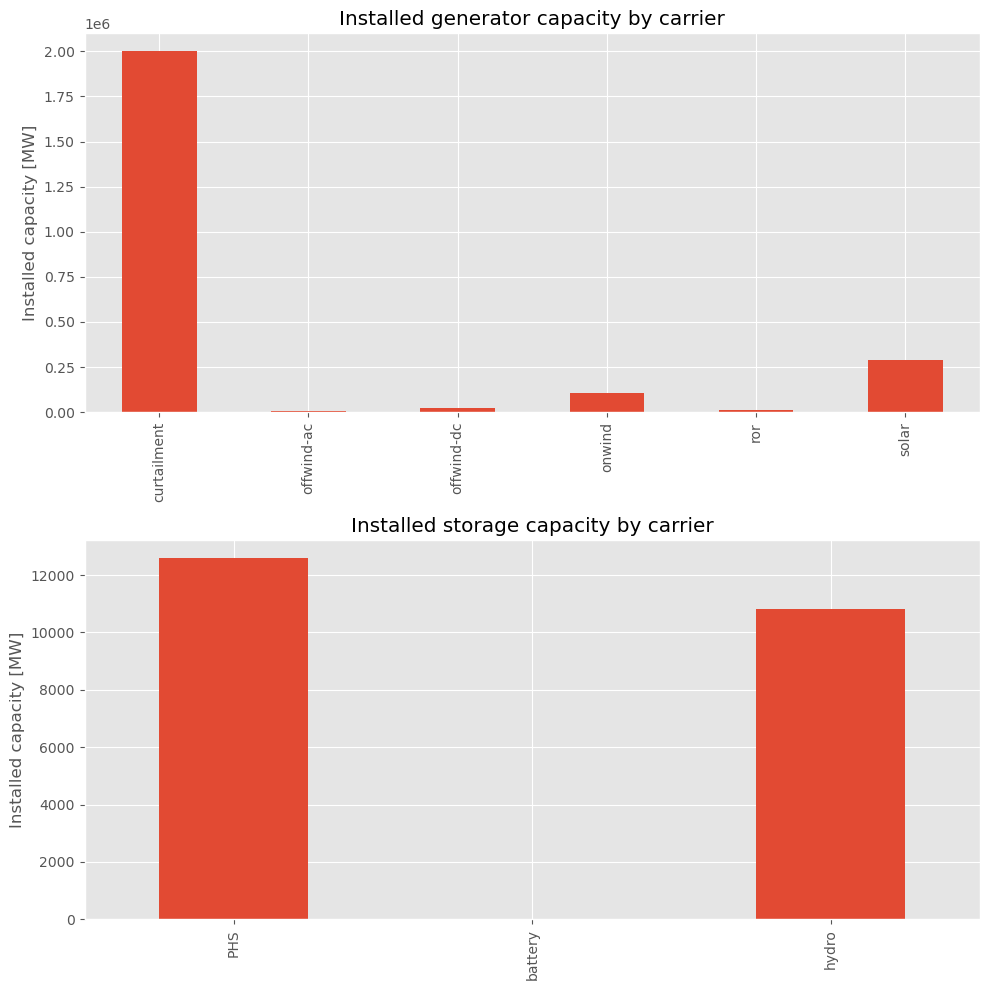

In [35]:
installed_generators = network.generators.groupby("carrier")["p_nom_opt"].sum()
installed_storage_units = network.storage_units.groupby("carrier")["p_nom_opt"].sum()

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

installed_generators.plot(kind="bar", ax=ax[0])
ax[0].set_xlabel("")
ax[0].set_ylabel("Installed capacity [MW]")
ax[0].set_title("Installed generator capacity by carrier")

installed_storage_units.plot(kind="bar", ax=ax[1])
ax[1].set_xlabel("")
ax[1].set_ylabel("Installed capacity [MW]")
ax[1].set_title("Installed storage capacity by carrier")

plt.tight_layout()

### Costs

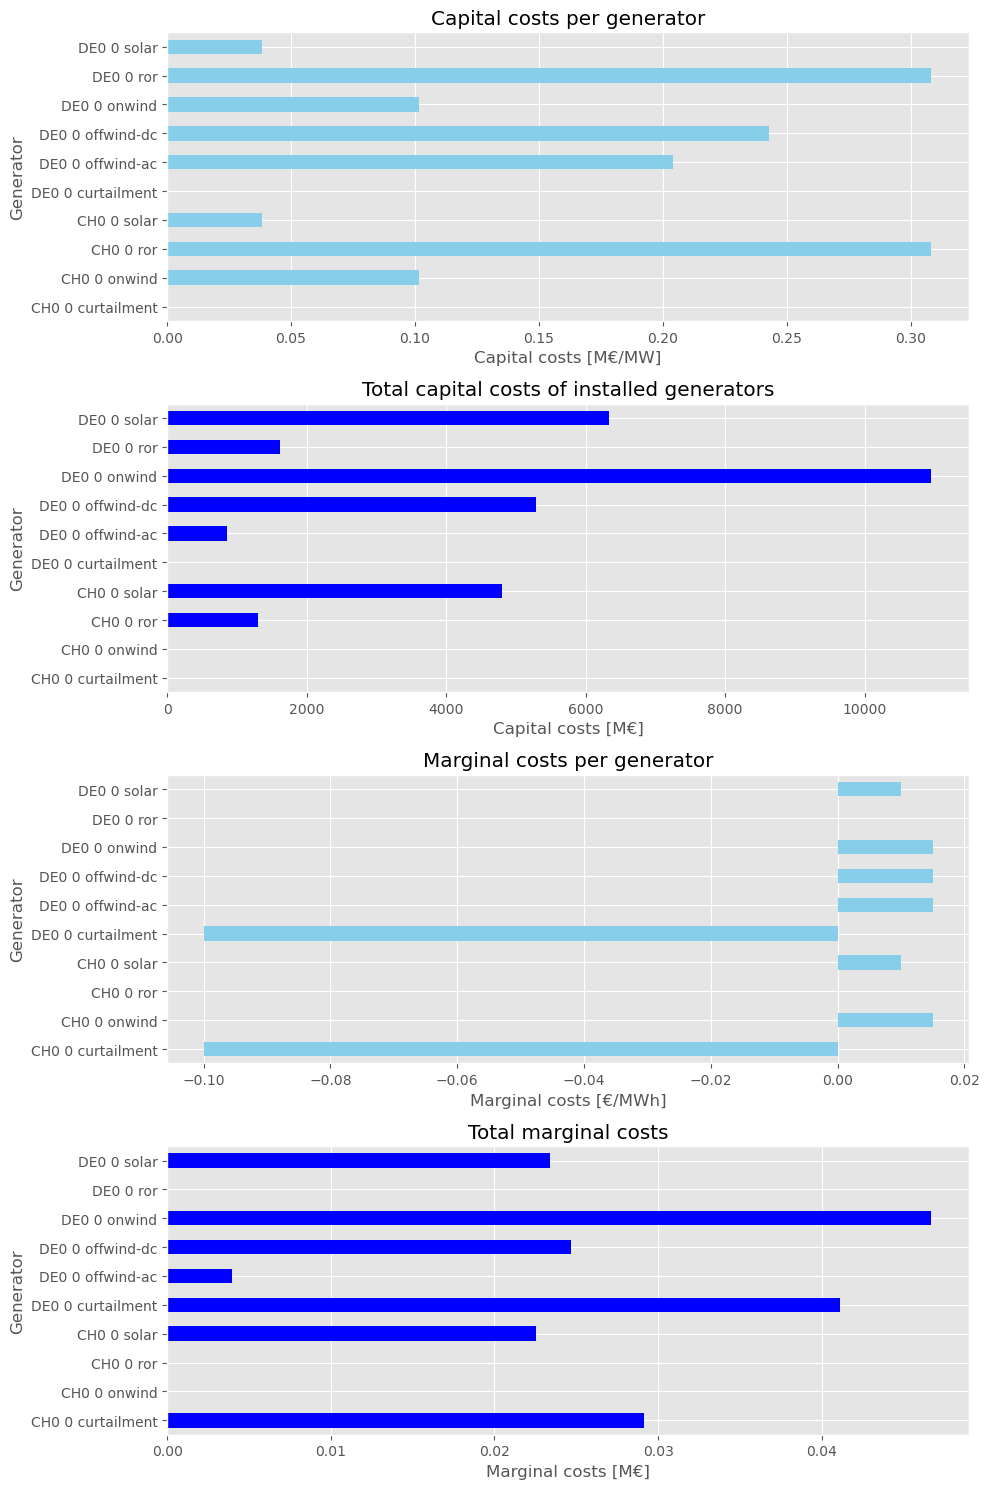

Total Capital Cost: 44.21 billion EUR
Total Operational Cost: 0.00 billion EUR


In [36]:
capital_costs = network.generators.capital_cost.sort_index().div(1e6)  # M€/MW
capital_costs_installed = capital_costs * network.generators.p_nom_opt  # M€
marginal_costs = network.generators.marginal_cost.sort_index()  # €/MWh

time_interval = (network.snapshots[1] - network.snapshots[0]).total_seconds() / 3600  # hours
energy_produced = network.generators_t.p.sum() * time_interval  # MWh
marginal_costs_total = (network.generators.marginal_cost * network.generators_t.p).sum().sort_index() / 1e6  # M€

fig, ax = plt.subplots(4, 1, figsize=(10, 15))

capital_costs.plot(
    kind="barh", ax=ax[0], title="Capital costs per generator", color="skyblue"
)
ax[0].set_xlabel("Capital costs [M€/MW]")
ax[0].set_ylabel("Generator")

# plot total capital costs of installed generators by multiplying by p_nom_opt
capital_costs_installed.plot(
    kind="barh",
    ax=ax[1],
    title="Total capital costs of installed generators",
    color="blue",
)
ax[1].set_xlabel("Capital costs [M€]")
ax[1].set_ylabel("Generator")

# barplot of marginal costs per generator
marginal_costs.plot(
    kind="barh", ax=ax[2], title="Marginal costs per generator", color="skyblue"
)
ax[2].set_xlabel("Marginal costs [€/MWh]")
ax[2].set_ylabel("Generator")

# barplot of total marginal costs
marginal_costs_total.plot(
    kind="barh", ax=ax[3], title="Total marginal costs", color="blue"
)
ax[3].set_xlabel("Marginal costs [M€]")
ax[3].set_ylabel("Generator")

plt.tight_layout()
plt.show()

capex = (
    (network.generators.p_nom_opt * network.generators.capital_cost).sum()
    + (network.links.p_nom_opt * network.links.capital_cost).sum()
    + (network.storage_units.p_nom_opt * network.storage_units.capital_cost).sum()
) / 1e9  # Convert to billion EUR

print(f"Total Capital Cost: {capex:.2f} billion EUR")

opex = (
    (network.generators_t.p * network.generators.marginal_cost).sum().sum()
) / 1e9  # Convert to billion EUR

print(f"Total Operational Cost: {opex:.2f} billion EUR")

## Dynamic variables


Display simultaneously:
* demand (load)
* generator dispatch
* storage consumption and production


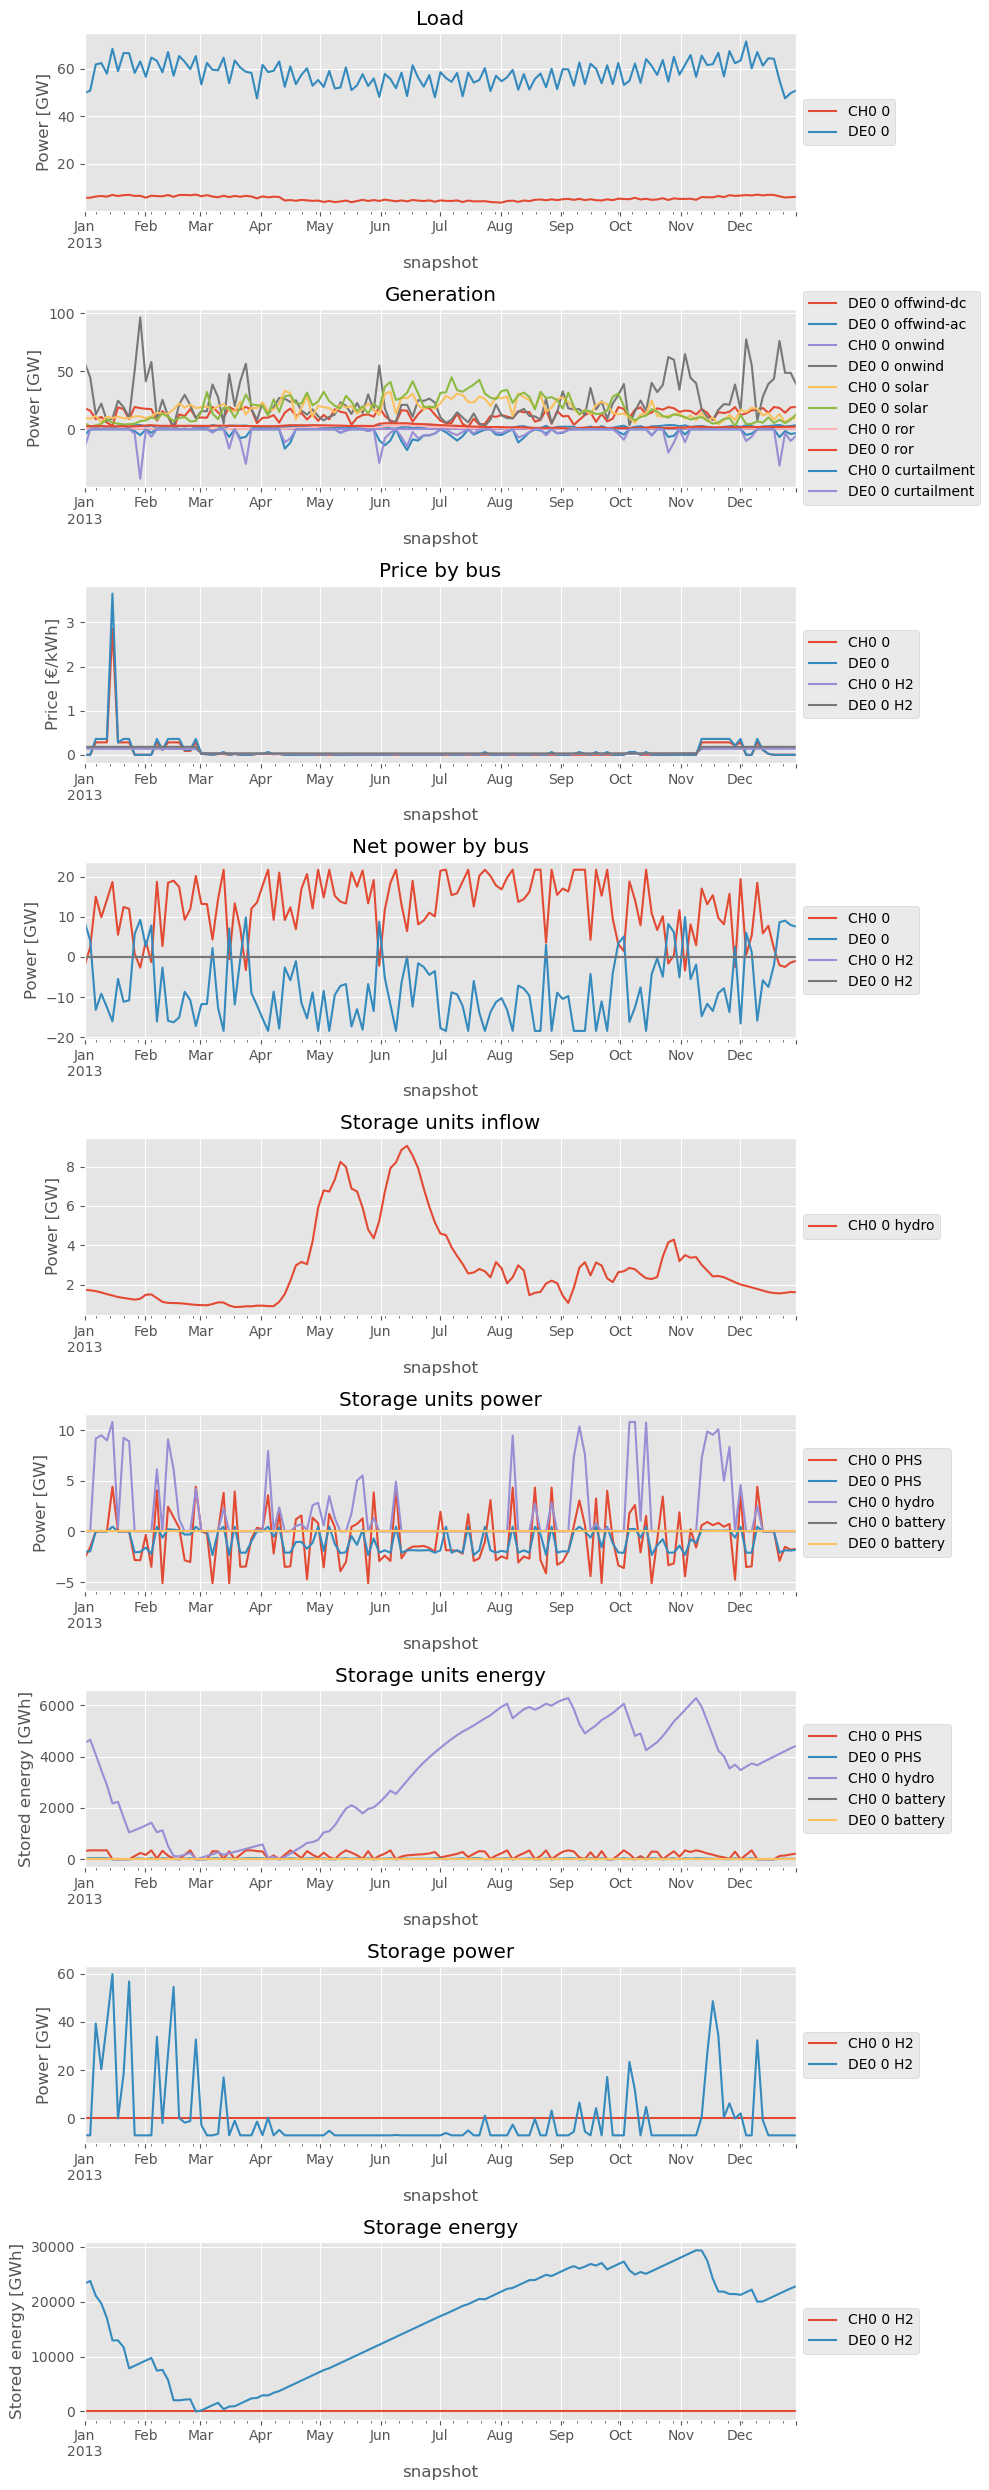

In [37]:
load_p_by_bus = network.loads_t.p.div(1e3)
gen_p_by_gen = network.generators_t.p.div(1e3)
price_by_bus = network.buses_t.marginal_price.div(1e3)  # in €/kWh
p_by_bus = network.buses_t.p.div(1e3)
storage_units_inflow_by_unit = network.storage_units_t.inflow.div(1e3)
storage_units_p_by_unit = network.storage_units_t.p.div(1e3)
storage_units_e_by_unit = network.storage_units_t.state_of_charge.div(1e3)
stores_p_by_store = network.stores_t.p.div(1e3)
store_e_by_store = network.stores_t.e.div(1e3)

# plot all
fig, ax = plt.subplots(9, 1, figsize=(10, 25))

load_p_by_bus.plot(ax=ax[0])
ax[0].set_title("Load")
ax[0].set_ylabel("Power [GW]")
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))

gen_p_by_gen.plot(ax=ax[1])
ax[1].set_title("Generation")
ax[1].set_ylabel("Power [GW]")
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

price_by_bus.plot(ax=ax[2])
ax[2].set_title("Price by bus")
ax[2].set_ylabel("Price [€/kWh]")
ax[2].legend(loc="center left", bbox_to_anchor=(1, 0.5))

p_by_bus.plot(ax=ax[3])
ax[3].set_title("Net power by bus")
ax[3].set_ylabel("Power [GW]")
ax[3].legend(loc="center left", bbox_to_anchor=(1, 0.5))

storage_units_inflow_by_unit.plot(ax=ax[4])
ax[4].set_title("Storage units inflow")
ax[4].set_ylabel("Power [GW]")
ax[4].legend(loc="center left", bbox_to_anchor=(1, 0.5))

storage_units_p_by_unit.plot(ax=ax[5])
ax[5].set_title("Storage units power")
ax[5].set_ylabel("Power [GW]")
ax[5].legend(loc="center left", bbox_to_anchor=(1, 0.5))

storage_units_e_by_unit.plot(ax=ax[6])
ax[6].set_title("Storage units energy")
ax[6].set_ylabel("Stored energy [GWh]")
ax[6].legend(loc="center left", bbox_to_anchor=(1, 0.5))

stores_p_by_store.plot(ax=ax[7])
ax[7].set_title("Storage power")
ax[7].set_ylabel("Power [GW]")
ax[7].legend(loc="center left", bbox_to_anchor=(1, 0.5))

store_e_by_store.plot(ax=ax[8])
ax[8].set_title("Storage energy")
ax[8].set_ylabel("Stored energy [GWh]")
ax[8].legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()

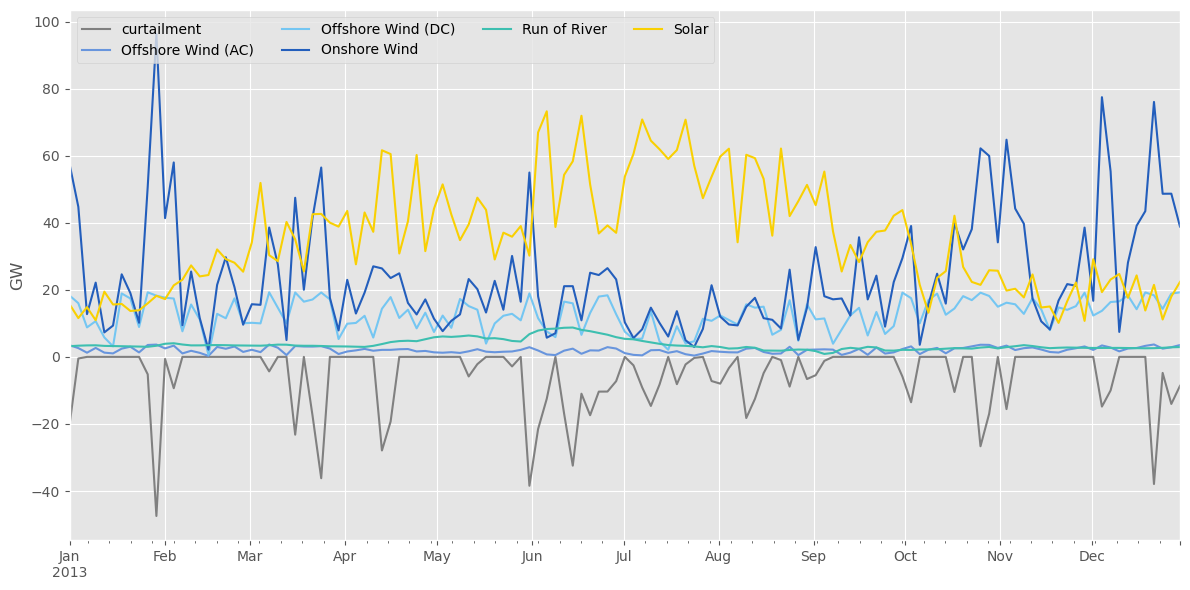

In [38]:
p_by_generator = (
    network.generators_t.p.T.groupby(network.generators.carrier).sum().T / 1e3
)  # unis of GW

all_colors = config["plotting"]["tech_colors"]

colors = []
for col in p_by_generator.columns:
    try:
        colors.append(all_colors[col])
    except KeyError:
        colors.append("gray")

p_by_generator.rename(columns=config["plotting"]["nice_names"], inplace=True)

fig, ax = plt.subplots(figsize=(12, 6))
p_by_generator.plot(kind="line", ax=ax, color=colors)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()